https://render.githubusercontent.com/view/ipynb?commit=0a25604af68824dc0def18dc9c64fd6e3316c68d&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f7370726f2f70726163746963616c2d7079746f7263682f306132353630346166363838323464633064656631386463396336346664366533333136633638642f636861722d726e6e2d636c617373696669636174696f6e2f636861722d726e6e2d636c617373696669636174696f6e2e6970796e62&nwo=spro%2Fpractical-pytorch&path=char-rnn-classification%2Fchar-rnn-classification.ipynb&repository_id=79684696&repository_type=Repository#Creating-the-Network

In [1]:
# Author: Ellis Brown
# http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

import random
import string
import math
import csv
import unicodedata
import nltk
import time
from nltk.corpus import names
from nltk.classify import apply_features
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from data_util import *

In [2]:
# dataset_filename = "nltk_mbejda.csv"
len(load_dataset())

135640

In [3]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

## Train

In [5]:
n_hidden = 128
n_epochs = 100000
print_every = 5000
plot_every = 1000
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
batch_size = 16
visdom = False
num_workers = 2
start_iter = 0 # Begin counting iterations starting from this value (should be used with resume)
max_iter = 120000
stepvalues = (80000, 100000, 120000)


In [14]:
rnn = RNN(n_letters, n_hidden, n_genders)
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [ ]:
def train():
    rnn.train()
    # loss counters
    ep_loss = 0  # epoch
    epoch = 0
    print('Loading Dataset...')
    
    dataset = NameGenderDataset(trainset)
    data_loader = data.DataLoader(dataset, batch_size, num_workers=num_workers,
                                  shuffle=True, collate_fn=name_gender_collate)
    
    epoch_size = len(dataset) // args.batch_size
    print('Training Name2Gender RNN on', DATASET_FN)
       
    batch_iterator = None
    step_index = 0
    for iteration in range(start_iter, max_iter):
        if (not batch_iterator) or (iteration % epoch_size == 0):
            # create batch iterator
            batch_iterator = iter(data_loader)
        if iteration in stepvalues:
            step_index += 1
#             adjust_learning_rate(optimizer, args.gamma, step_index)
            # reset epoch loss counters
            ep_loss = 0
            epoch += 1

        # load train data
        names, genders = next(batch_iterator)

        # forward
        t0 = time.time()
        out = rnn(names)
        # backprop
        optimizer.zero_grad()
        loss_l, loss_c = criterion(out, targets)
        loss = loss_l + loss_c
        loss.backward()
        optimizer.step()
        t1 = time.time()
        loc_loss += loss_l.data[0]
        conf_loss += loss_c.data[0]
        if iteration % 10 == 0:
            print('Timer: %.4f sec.' % (t1 - t0))
            print('iter ' + repr(iteration) + ' || Loss: %.4f ||' % (loss.data[0]), end=' ')
        if iteration % 5000 == 0:
            print('Saving state, iter:', iteration)
            torch.save(ssd_net.state_dict(), 'weights/ssd300_0712_' +
                       repr(iteration) + '.pth')
    

In [15]:
def train(gender_tensor, name_tensor):
    hidden = rnn.init_hidden()
    optimizer.zero_grad()
    
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    loss = criterion(output, gender_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.data[0]

In [16]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [40]:
start = time.time()

print("Beginning training...")
for epoch in range(1, n_epochs + 1):
    gender, name, gender_tensor, name_tensor = random_training_pair()
    output, loss = train(gender_tensor, name_tensor)
    current_loss += loss

    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = gender_from_output(output)
        correct = '✓' if guess == gender else '✗ (%s)' % gender
        print('%d %d%% (%s) %.4f %s -> %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, name, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

Beginning training...
5000 5% (8m 38s) 0.0157 wileyjr -> male ✓
10000 10% (16m 48s) 1.0177 legary -> female ✗ (male)
15000 15% (25m 43s) 0.0237 almeda -> female ✓
20000 20% (34m 39s) 0.0621 celisse -> female ✓
25000 25% (42m 40s) 0.0361 alysha -> female ✓
30000 30% (51m 25s) 0.1796 izak -> male ✓
35000 35% (60m 54s) 0.2059 jessies -> male ✓
40000 40% (69m 24s) 0.2944 cornie -> female ✓
45000 45% (79m 15s) 0.0172 babetta -> female ✓
50000 50% (88m 0s) 1.3238 andre -> female ✗ (male)
55000 55% (97m 24s) 0.5883 renel -> female ✓
60000 60% (106m 26s) 0.1350 crissie -> female ✓
65000 65% (115m 33s) 1.0983 dareen -> male ✗ (female)
70000 70% (124m 26s) 0.0488 natasia -> female ✓
75000 75% (133m 50s) 0.1220 jaine -> female ✓
80000 80% (143m 31s) 0.7056 scott -> female ✗ (male)
85000 85% (163m 5s) 0.2099 romires -> male ✓
90000 90% (179m 7s) 0.2749 russ -> male ✓
95000 95% (187m 26s) 0.0133 cresta -> female ✓
100000 100% (196m 26s) 0.6030 jodie -> female ✓


In [41]:
torch.save(rnn, 'gender-rnn-classification2.pt')

/usr/local/Anaconda3-4.4.0-Linux-x86_64/envs/jupyter-atp/lib/python3.5/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


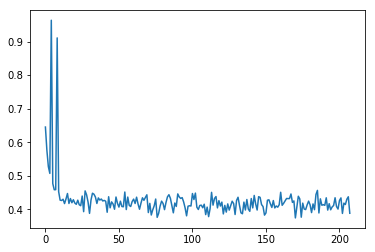

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Evaluate

In [23]:
rnn = torch.load('gender-rnn-classification.pt')

In [27]:
def evaluate(name_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    
    return output

## Predict

In [28]:
def predict(name, n_predictions=2):
    output = evaluate(Variable(name_to_tensor(name)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        gender_index = topi[0][i]
        print('(%.2f) %s' % (value, all_genders[gender_index]))
        predictions.append([value, all_genders[gender_index]])

    return predictions

In [39]:
predict("jeremy")

(-0.35) male
(-1.23) female


[[-0.3476564586162567, 'male'], [-1.2253377437591553, 'female']]